In [38]:
import pandas as pd
pd.set_option("display.max_columns", 75)

## Cleaning Data

In [39]:
nbaData = "NBAdata.csv"
# drop unwanted values
temp = pd.read_csv(nbaData)
data = temp.copy()
data = data.drop('#', axis=1)
data = data.drop('blank2', axis=1)
data = data.drop('blanl', axis=1)

# rename columns
data.rename(columns={"Season Start": "Season"}, inplace=True)
data.rename(columns={"Tm": "Team"}, inplace=True)
data.rename(columns={"Player Name": "Name"}, inplace=True)
data.rename(columns={"Player Salary in $": "Salary"}, inplace=True)
data.rename(columns={"G": "GP"}, inplace=True)

# we can assign the positions numberical values
positions = {'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5}
data['Pos'] = data['Pos'].map(positions)

# ratio of Games Started to Games Played
data["GS/GP"] = data["GS"] / data["GP"]

# last row is null
data = data[:-1]

In [40]:
# since the stats in our data are cumulative, we must convert them to per-game data
# stats should be a on a per-game basis instead of totals to eliminate the effect of games played
data["MPG"] = data["MP"]/data["GP"]
data["ORPG"] = data["ORB"]/data["GP"]
data["DRPG"] = data["DRB"]/data["GP"]
data["RPG"] = data["TRB"]/data["GP"]
data["APG"] = data["AST"]/data["GP"]
data["SPG"] = data["STL"]/data["GP"]
data["BPG"] = data["BLK"]/data["GP"]
data["TPG"] = data["TOV"]/data["GP"]
data["PFPG"] = data["PF"]/data["GP"]
data["PPG"] = data["PTS"]/data["GP"]
data["FGPG"] = data["FG"]/data["GP"]
data["FGAPG"] = data["FGA"]/data["GP"]
data["3PPG"] = data["3P"]/data["GP"]
data["3PAPG"] = data["3PA"]/data["GP"]
data["2PPG"] = data["2P"]/data["GP"]
data["2PAPG"] = data["2PA"]/data["GP"]
data["FTPG"] = data["FT"]/data["GP"]
data["FTAPG"] = data["FTA"]/data["GP"]

#drop all total columns
drop_column = ['MP', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
               'PF', 'PTS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA']
data.drop(drop_column, axis=1, inplace=True)

In [41]:
# splitting stats into 3 categories for later
adv_data = ['% of Cap', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
            'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
reg_data = ['% of Cap', 'ORPG', 'DRPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'PFPG',
           'PPG', 'FGPG', 'FGAPG', '3PPG', '3PAPG', '2PPG', '2PAPG', 'FTPG', 'FTAPG']
data['Salary'] = data.Salary.astype(float)

data['Name'] = data['Name'].map(lambda x: x.rstrip('*'))


In [42]:
# handling invalid values and special cases
data = data[-data["Team"].str.contains("TOT", na=False)]

# get players who have played at least 20 games
data = data[data['GP']>=20]

# missing salary values are a no-go
data = data.dropna(subset=['Salary'])

null_value = ['TS%', '3PAr', 'FTr', 'TOV%', 'FG%', '3P%', '2P%', 'eFG%', 'FT%']
for i in null_value:
    data[i].fillna(0, inplace=True)


In [43]:
print(len(data['Team'].unique()))
# are there 38 teams in the NBA?
# we must handle the name changes of franchises since 1995 such as the Charlotte Hornets, New Orleans Pelicans, and others
data["Team"].replace("CHH", "NOP", inplace=True)
data["Team"].replace("NOH", "NOP", inplace=True)
data["Team"].replace("NOK", "NOP", inplace=True)
data["Team"].replace("NJN", "BRK", inplace=True)
data["Team"].replace("WSB", "WAS", inplace=True)
data["Team"].replace("SEA", "OKC", inplace=True)
data["Team"].replace("VAN", "MEM", inplace=True)
data["Team"].replace("CHA", "CHO", inplace=True)

# we now have the correct number of teams represented in the dataset
print(len(data['Team'].unique()))


38
30


### The Salary Cap

[]

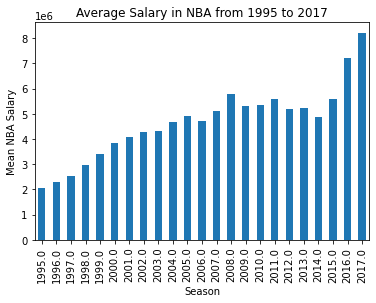

In [44]:
from pandas import *
salary_cap = pd.read_excel('salaryCap.xlsx', index_col=0).to_dict()
cap=salary_cap['Salary Cap']

# How has the average NBA changed over the years?
mean_salary = data.groupby('Season')['Salary'].mean()
salary_plot = mean_salary.plot.bar(x='Season', y='Salary')
salary_plot.set_ylabel("Mean NBA Salary")
salary_plot.set_title("Average Salary in NBA from 1995 to 2017")
salary_plot.plot()


The average NBA salary has increased dramatically over the last decade so it does not make much sense to run our regression on the absolute salary values. Instead, we can calculate the salary value as % of Cap. 

In [45]:
data['Cap'] = data['Season'].map(cap)
data['% of Cap'] = (data['Salary']/data['Cap'])*100

salary = data['Salary']
data = data.drop('Salary', axis=1)

# the final dataset that we will train our model on
data

,Season,Name,Pos,Age,Team,GP,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,3P%,2P%,eFG%,FT%,GS/GP,MPG,ORPG,DRPG,RPG,APG,SPG,BPG,TPG,PFPG,PPG,FGPG,FGAPG,3PPG,3PAPG,2PPG,2PAPG,FTPG,FTAPG,Cap,% of Cap
0,1995.0,A.C. Green,3.0,31.0,PHO,82.0,52.0,14.2,0.596,0.206,0.556,8.3,20.4,14.3,6.5,1.0,0.8,12.9,14.2,4.6,2.1,6.7,0.120,0.6,0.2,0.7,1.9,0.504,0.339,0.547,0.539,0.732,0.634146,32.768293,2.365854,5.792683,8.158537,1.548780,0.670732,0.378049,1.390244,1.780488,11.170732,3.792683,7.524390,0.524390,1.548780,3.268293,5.975610,3.060976,4.182927,23000000,28.143478
1,1995.0,Aaron McKie,2.0,22.0,POR,45.0,20.0,13.3,0.500,0.107,0.280,4.6,13.5,8.8,15.9,2.2,1.4,11.7,17.0,0.8,1.2,2.0,0.115,-1.2,1.3,0.1,0.4,0.444,0.393,0.451,0.466,0.685,0.444444,18.377778,0.777778,2.088889,2.866667,1.977778,0.800000,0.355556,0.866667,2.155556,6.511111,2.577778,5.800000,0.244444,0.622222,2.333333,5.177778,1.111111,1.622222,23000000,3.673913
4,1995.0,Acie Earl,5.0,24.0,BOS,30.0,3.0,6.6,0.409,0.000,0.426,10.4,14.6,12.5,1.4,1.5,2.6,14.8,19.7,-0.4,0.2,-0.2,-0.038,-6.8,-1.9,-8.7,-0.4,0.382,0.000,0.382,0.382,0.483,0.100000,6.933333,0.633333,0.866667,1.500000,0.066667,0.200000,0.266667,0.466667,1.300000,2.200000,0.866667,2.266667,0.000000,0.000000,0.866667,2.266667,0.466667,0.966667,23000000,4.521739
5,1995.0,Adam Keefe,3.0,24.0,UTA,75.0,0.0,15.1,0.616,0.000,0.581,14.0,18.0,16.1,3.5,1.5,1.6,14.2,15.6,2.4,1.7,4.1,0.154,0.6,0.2,0.8,0.9,0.577,0.000,0.577,0.577,0.676,0.000000,16.933333,1.800000,2.560000,4.360000,0.400000,0.480000,0.333333,0.826667,1.880000,6.146667,2.293333,3.973333,0.000000,0.000000,2.293333,3.973333,1.560000,2.306667,23000000,7.173913
11,1995.0,Alonzo Mourning,5.0,24.0,NOP,77.0,77.0,20.1,0.593,0.031,0.585,8.4,21.6,15.3,6.6,0.9,5.5,14.8,25.6,4.3,5.1,9.4,0.153,-0.8,2.1,1.3,2.5,0.519,0.324,0.525,0.524,0.761,1.000000,38.194805,2.597403,7.285714,9.883117,1.441558,0.636364,2.922078,3.129870,3.571429,21.337662,7.415584,14.298701,0.142857,0.441558,7.272727,13.857143,6.363636,8.363636,23000000,19.826087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12822,2017.0,Wilson Chandler,3.0,29.0,DEN,71.0,33.0,14.9,0.545,0.347,0.207,5.2,17.7,11.5,9.8,1.2,1.1,10.0,22.0,2.4,1.1,3.6,0.078,0.5,-1.3,-0.8,0.7,0.461,0.337,0.527,0.520,0.727,0.464789,30.943662,1.450704,5.014085,6.464789,1.985915,0.732394,0.422535,1.605634,2.422535,15.732394,6.098592,13.225352,1.549296,4.591549,4.549296,8.633803,1.985915,2.732394,99093000,12.126844
12825,2017.0,Yogi Ferrell,1.0,23.0,DAL,36.0,29.0,14.1,0.541,0.432,0.212,1.7,9.7,5.5,24.1,2.0,0.6,12.9,19.5,1.0,0.9,2.0,0.090,0.5,-0.3,0.2,0.6,0.412,0.403,0.418,0.499,0.877,0.805556,29.055556,0.444444,2.305556,2.750000,4.305556,1.111111,0.194444,1.555556,2.194444,11.333333,3.944444,9.583333,1.666667,4.138889,2.277778,5.444444,1.777778,2.027778,99093000,1.324625
12826,2017.0,Zach LaVine,2.0,21.0,MIN,47.0,47.0,14.6,0.576,0.437,0.197,1.2,9.5,5.3,12.6,1.2,0.5,9.9,21.7,2.5,0.4,3.0,0.082,2.1,-2.4,-0.3,0.8,0.459,0.387,0.515,0.544,0.836,1.000000,37.212766,0.382979,3.000000,3.382979,2.957447,0.872340,0.212766,1.808511,2.212766,18.914894,6.936170,15.106383,2.553191,6.595745,4.382979,8.510638,2.489362,2.978723,99093000,3.231527
12827,2017.0,Zach Randolph,4.0,35.0,MEM,73.0,5.0,18.5,0.490,0.098,0.200,11.3,27.4,19.1,13.5,1.1,0.5,8.6,29.2,0.8,2.4,3.2,0.086,-1.4,-0.7,-2.1,0.0,0.449,0.223,0.474,0.460,0.731,0.068493,24.465753,2.493151,5.698630,8.191781,1.671233,0.520548,0.136986,1.356164,1.863014,14.082192,5.931507,13.205479,0.287671,1.287671,5.643836,11.917808,1.931507,2.643836,99093000,12.420345
